# **LOAD LIBRARIES**

In [2]:
!pip install torchaudio -q --no-deps
!pip install speechbrain -q
!pip install spectralcluster -q
!pip install pyannote.metrics -q
!pip install gdown -q

     |████████████████████████████████| 1.9MB 9.3MB/s 
     |████████████████████████████████| 358kB 10.3MB/s 
     |████████████████████████████████| 1.2MB 17.1MB/s 
     |████████████████████████████████| 645kB 44.8MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 552kB 35.1MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 133kB 12.8MB/s 


In [1]:
# Download util module
!gdown --id 1XltkNas1LTOck62GIDYT0WcPDPGZEo7P

# Download DEC module
!gdown --id 1FWIRF2Kq6JB0fFHwjkZmVfEuGq0-SSC5

# Download optimalSpeaker.py
!gdown --id 1hbepzjAxHTQS5QoAlKNP9zK0nMxdjauJ

# Download baselineMethods.py
!gdown --id 1RQkezkiXa5DVFHE7g4UKE2v8vcmgJFpm

Downloading...
From: https://drive.google.com/uc?id=1XltkNas1LTOck62GIDYT0WcPDPGZEo7P
To: /content/utils.py
100% 16.8k/16.8k [00:00<00:00, 13.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FWIRF2Kq6JB0fFHwjkZmVfEuGq0-SSC5
To: /content/DEC.py
100% 10.1k/10.1k [00:00<00:00, 18.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hbepzjAxHTQS5QoAlKNP9zK0nMxdjauJ
To: /content/optimumSpeaker.py
100% 7.08k/7.08k [00:00<00:00, 11.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RQkezkiXa5DVFHE7g4UKE2v8vcmgJFpm
To: /content/baselineMethods.py
100% 4.39k/4.39k [00:00<00:00, 7.48MB/s]


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import os
import torch
from torch.utils.data import Dataset, DataLoader
from speechbrain.pretrained import SpeakerRecognition
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, SpectralClustering
from sklearn import decomposition
from tqdm.auto import tqdm

from utils import DiarizationDataSet, get_metrics, plot_annot
import baselineMethods
from DEC import diarizationDEC

import shutil
import pandas as pd

# Download dataset

In [6]:
audio_dataset = DiarizationDataSet(dataset_name='voxconverse',
                                   window_len=1500, 
                                   window_step=750,
                                   split='test',
                                   use_oracle_vad=False)

print("\nData size:", len(audio_dataset))

Dataset already downloaded!


Downloading...
From: https://drive.google.com/uc?id=18oXqn9Zyt5tJpoEwKKztpTag-AJMQ2Sz
To: /content/tmp.zip
100%|██████████| 128k/128k [00:00<00:00, 15.8MB/s]


Download and Extraction Complete
Precomputed X-vectors exists!
Will use precomputed features...



Downloading...
From: https://drive.google.com/uc?id=1-2-AZnabTtHxLmw2DBwj4PJDGwlvFa8J
To: /content/tmp.zip
69.4MB [00:00, 149MB/s] 


Download and Extraction Complete

Data size: 50


# Spectral - EigenGap

In [7]:
hypothesis_dir_spectral = baselineMethods.diarizationEigenGapNumSpkrs(audio_dataset, hypothesis_dir="./rttm_output_spectral/")
metric_spectral = get_metrics(audio_dataset.label_dir, hypothesis_dir_spectral)

# DEC

In [9]:
hypothesis_dir_dec = diarizationDEC(audio_dataset, hypothesis_dir="./rttm_output_dec/")
metric_dec = get_metrics(audio_dataset.label_dir, hypothesis_dir_dec)

# Compare

In [11]:
df_dec = metric_dec.report()
df_spectral = metric_spectral.report()

df_spectral = df_spectral[[df_dec.keys()[0]]]
df_dec = df_dec[[df_dec.keys()[0]]]

df_both = df_dec
df_both["DER (Spectral)"] = df_spectral[[df_dec.keys()[0]]]
df_both.columns = ["DER (DEC)", "DER (Spectral)"]

df_both["DER Difference"] = df_both["DER (Spectral)"]-df_both["DER (DEC)"]

df_both = df_both[:-1]
df_both = df_both.sort_values(by=['DER Difference'])

In [12]:
df_dec[-1:]

,DER (DEC),DER (Spectral),DER Difference
item,,,
TOTAL,12.990757,17.760788,4.770031


In [13]:
df_both

,DER (DEC),DER (Spectral),DER Difference
item,,,
qjgpl,58.585535,23.713084,-34.872451
mevkw,83.032581,54.461153,-28.571429
ehpau,31.754241,11.828713,-19.925528
falxo,61.040005,42.708300,-18.331705
cqaec,38.985241,29.348762,-9.636478
pilgb,15.796775,9.453537,-6.343239
luvfz,28.499016,24.426024,-4.072992
hgdez,13.055585,12.424016,-0.631569
dhorc,5.096795,4.546283,-0.550512


In [14]:
print("Better DER for", np.sum(df_both['DER Difference'].values>0), "examples.")
print("Poor DER for", np.sum(df_both['DER Difference'].values<0), "examples.")
print("Same DER for", np.sum(df_both['DER Difference'].values==0), "examples.")

Better DER for 32 examples.
Poor DER for 12 examples.
Same DER for 6 examples.


In [15]:
filenames = ["hgdez"] + list(df_both.index[[-1, -2, -3, 2, 1, 0]])


---------------------------
DEC
---------------------------



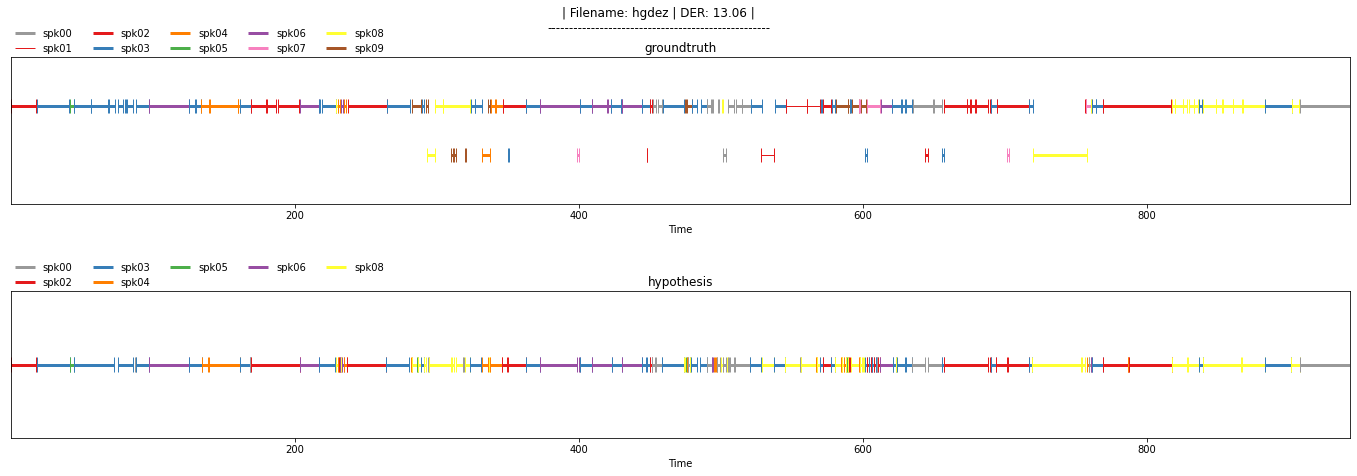


---------------------------
Spectral
---------------------------



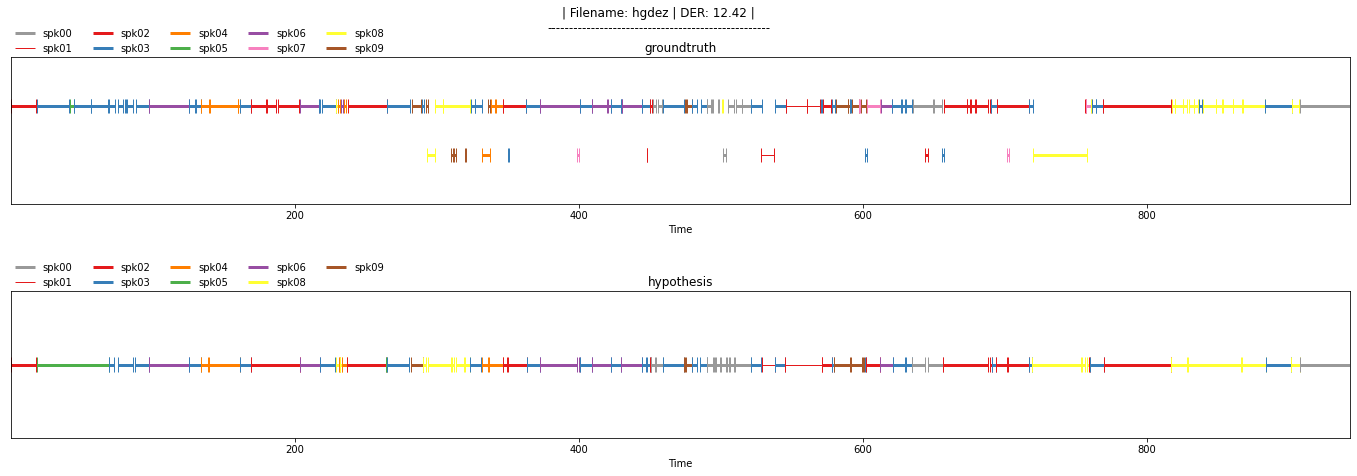


---------------------------
DEC
---------------------------



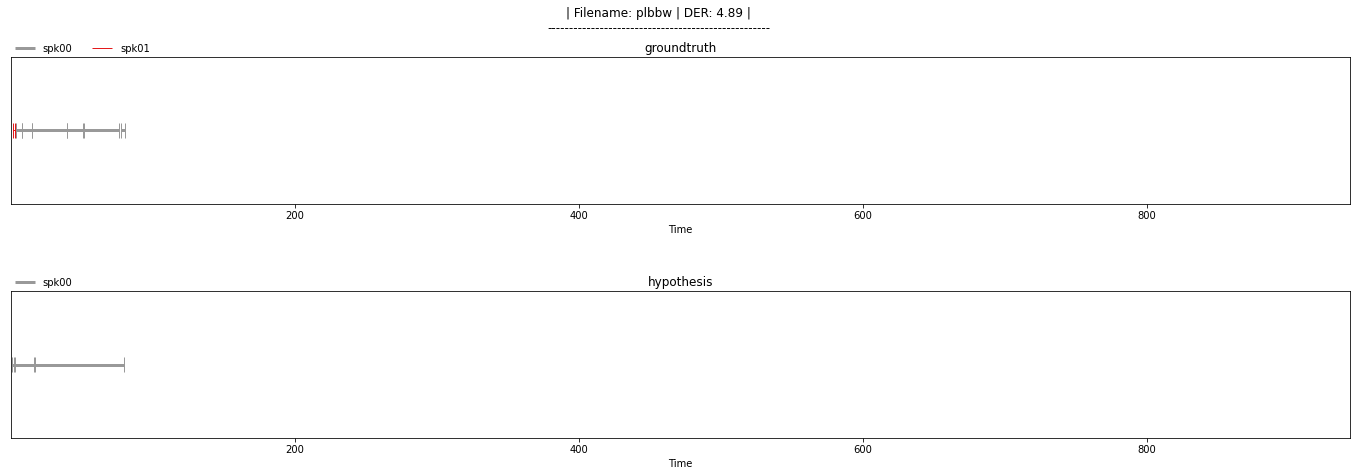


---------------------------
Spectral
---------------------------



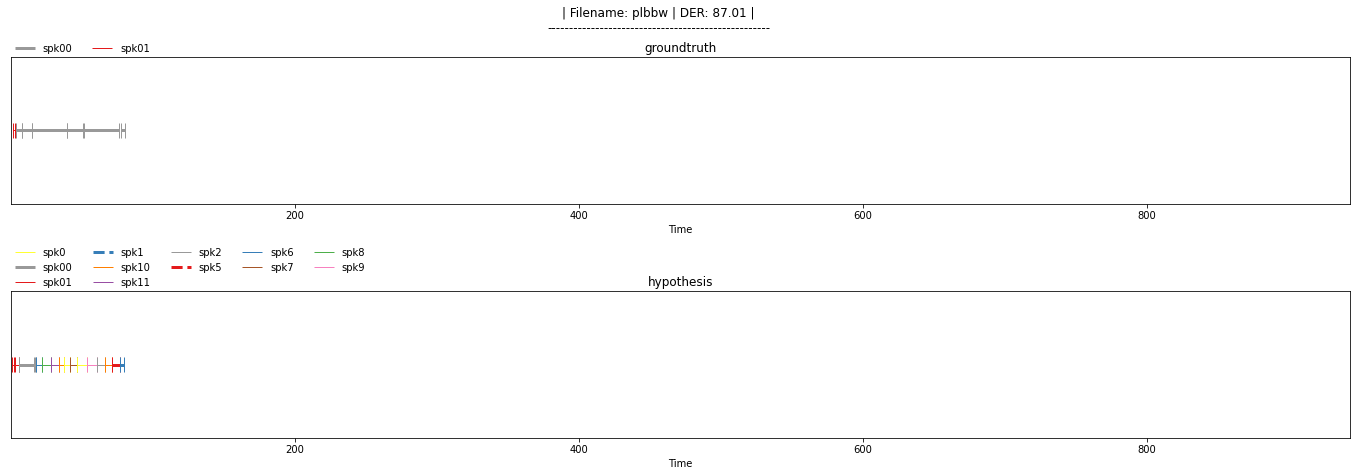


---------------------------
DEC
---------------------------



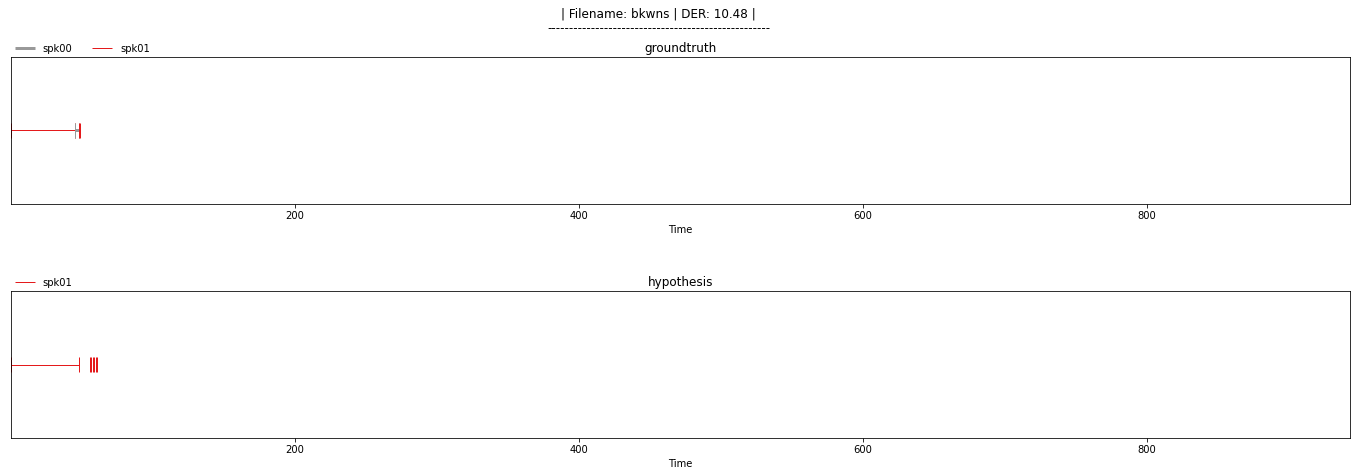


---------------------------
Spectral
---------------------------



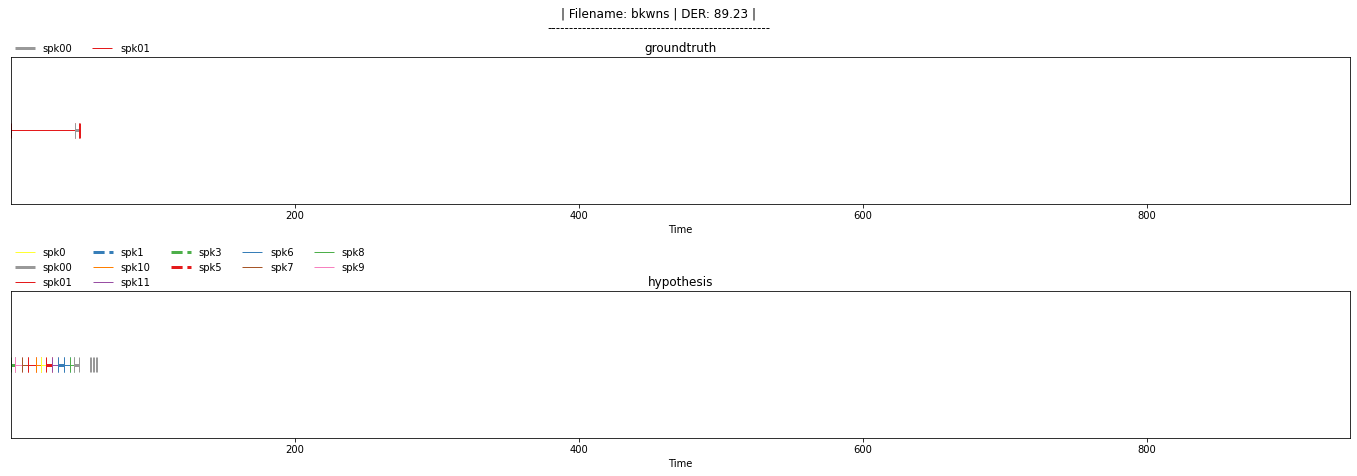


---------------------------
DEC
---------------------------



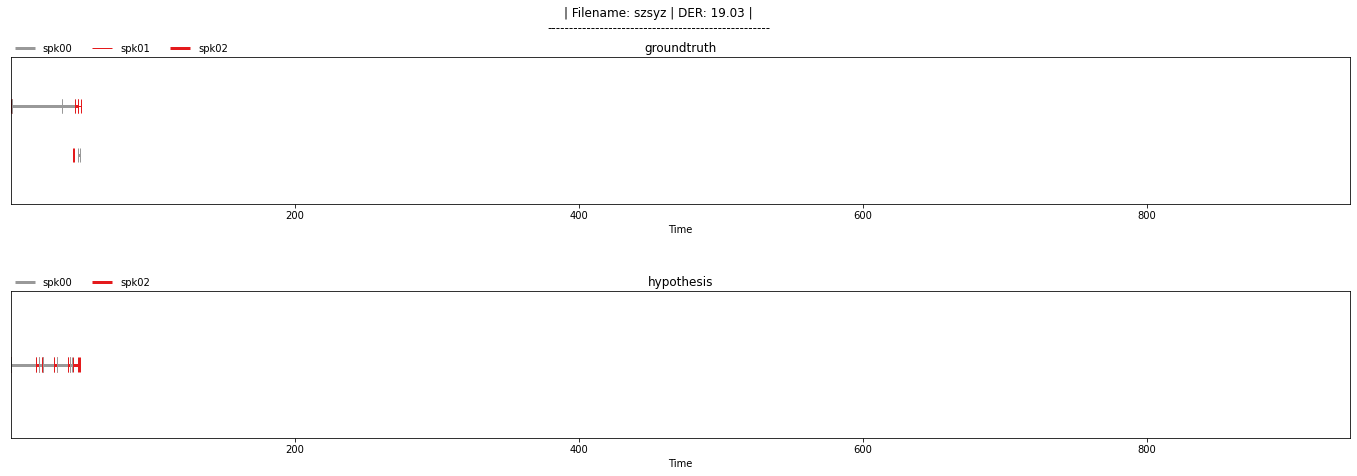


---------------------------
Spectral
---------------------------



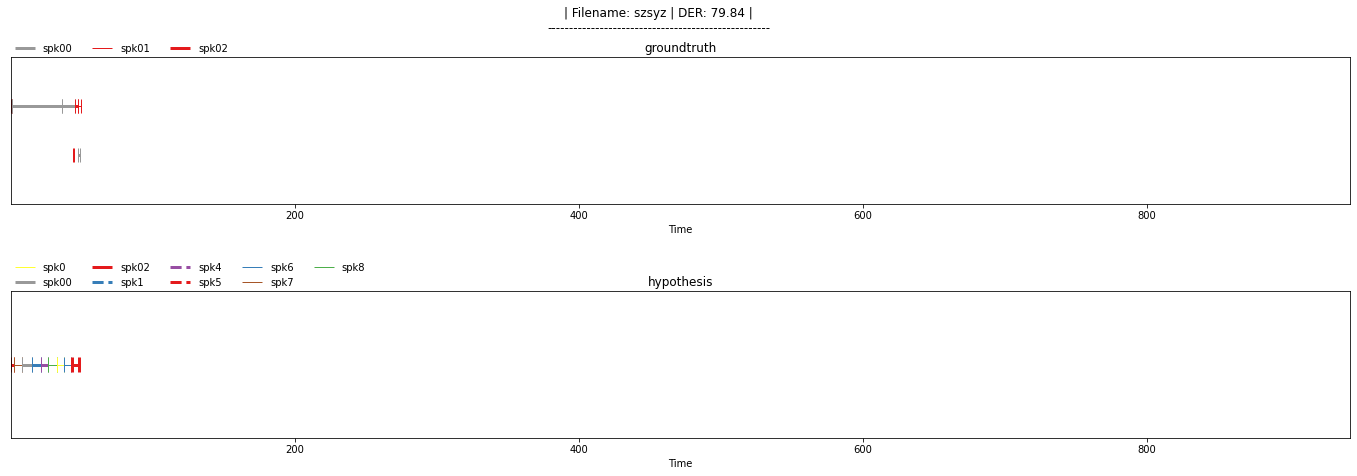


---------------------------
DEC
---------------------------



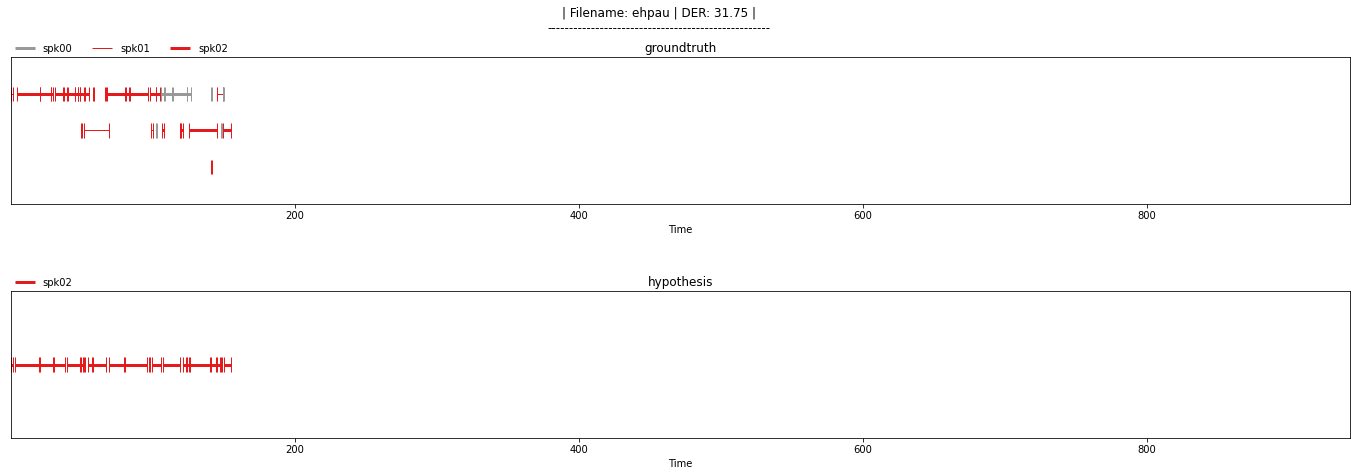


---------------------------
Spectral
---------------------------



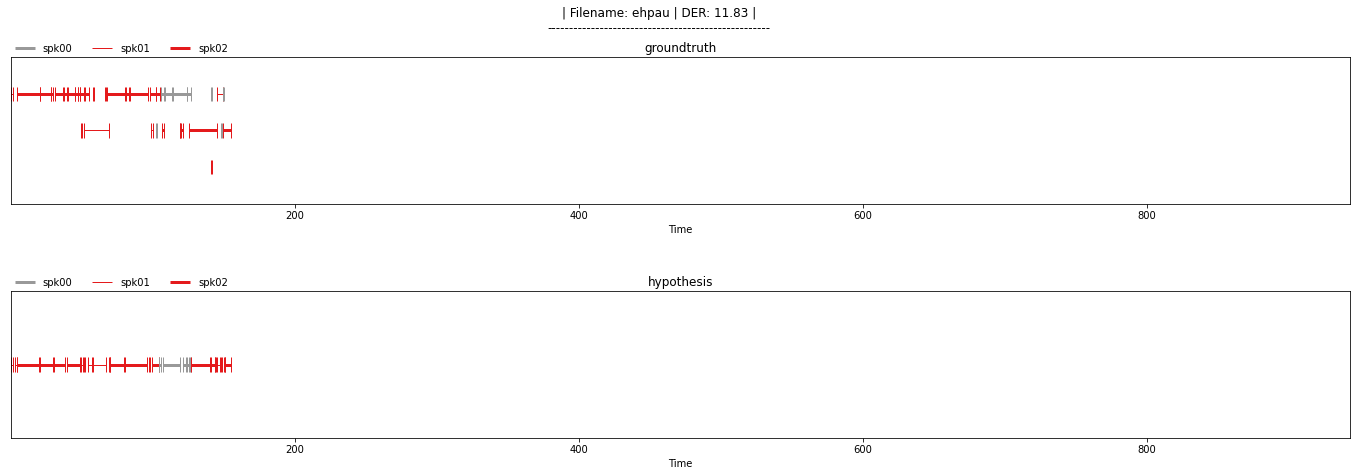


---------------------------
DEC
---------------------------



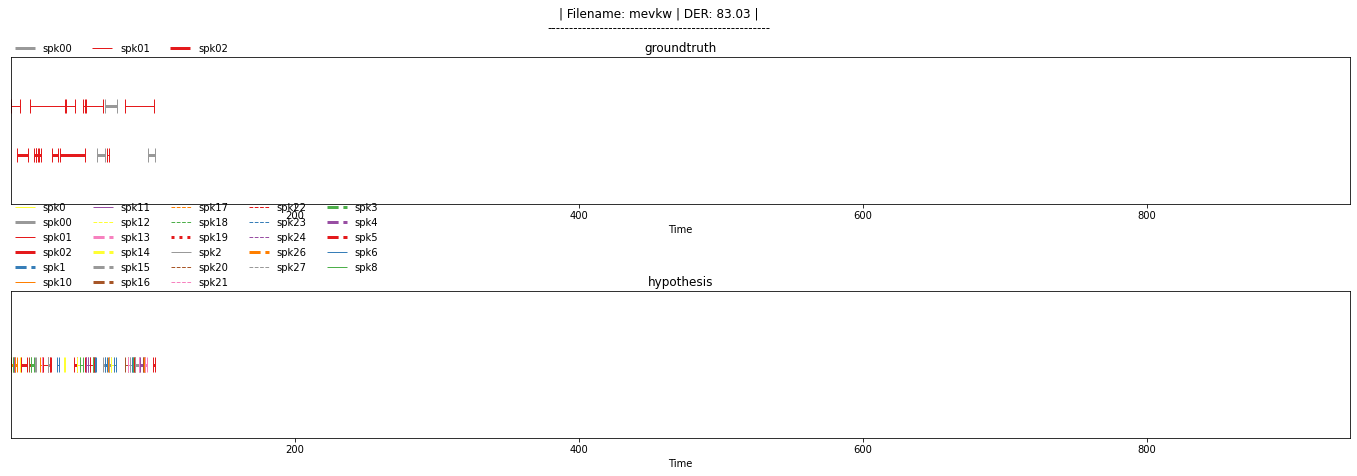


---------------------------
Spectral
---------------------------



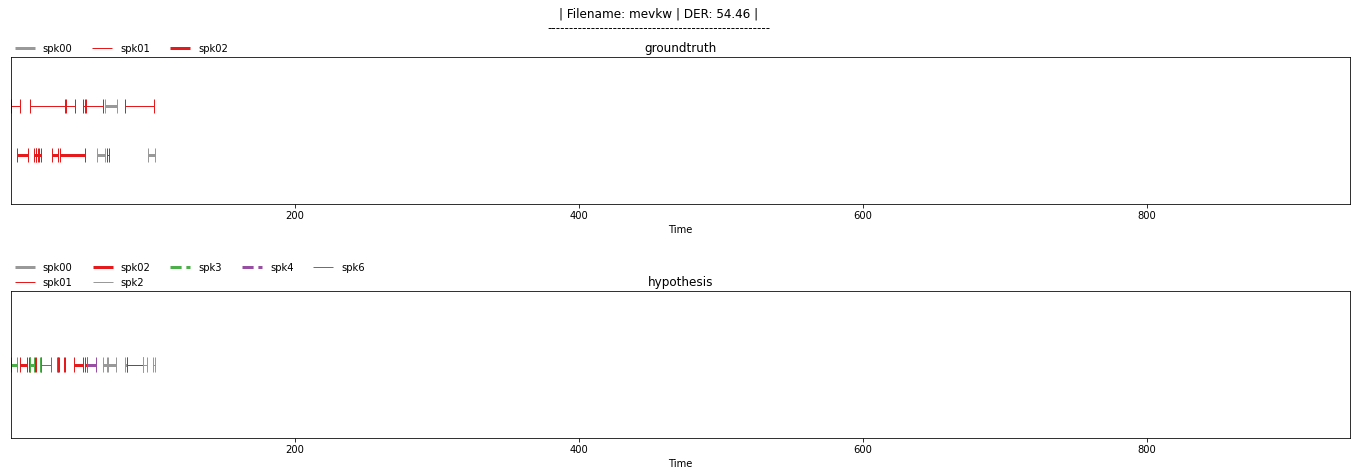


---------------------------
DEC
---------------------------



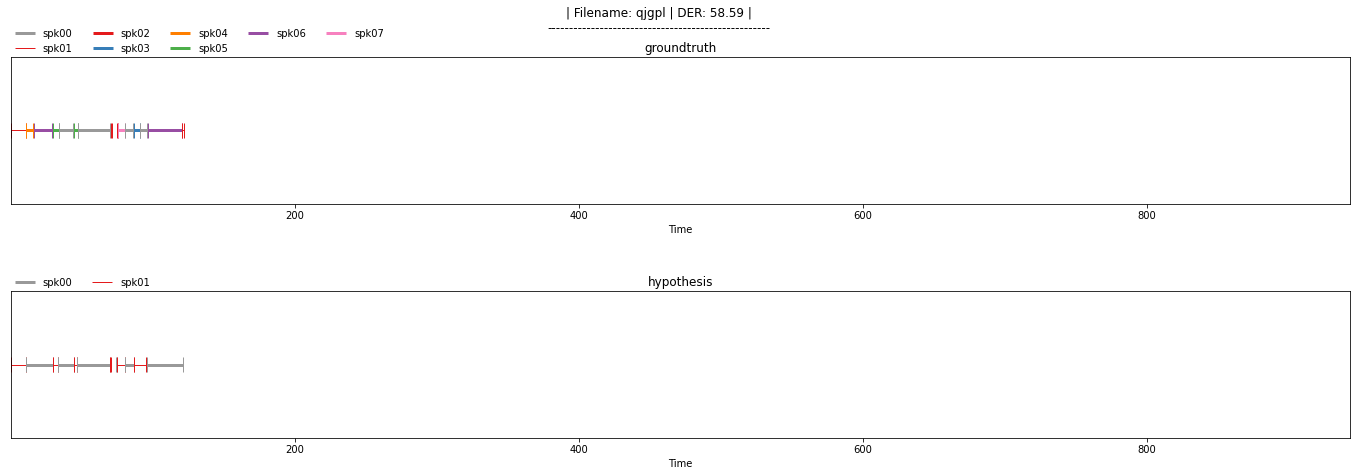


---------------------------
Spectral
---------------------------



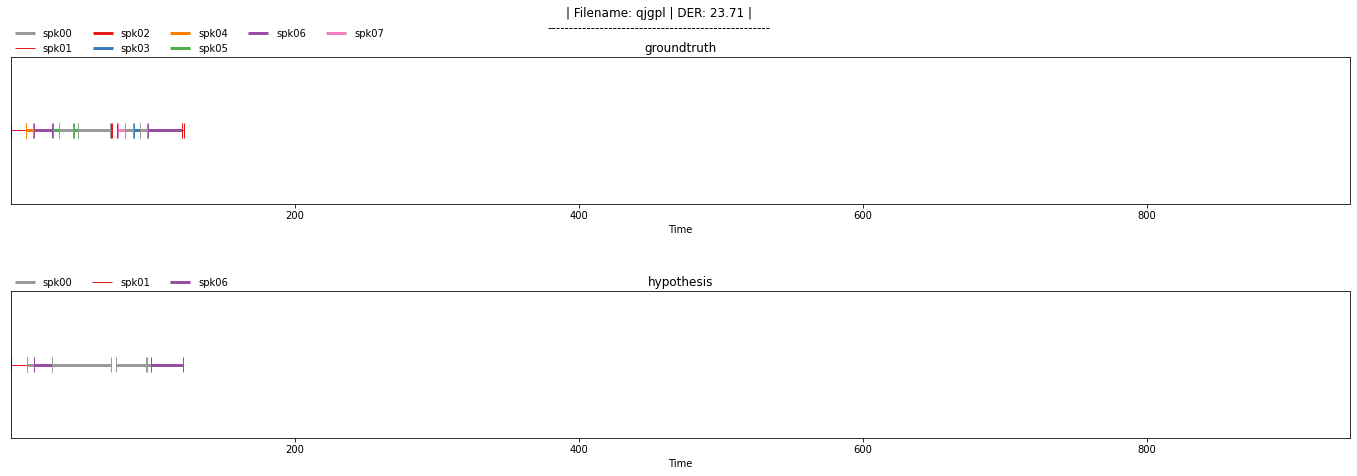

In [17]:
for name in filenames:
    print("\n---------------------------\nDEC\n---------------------------\n")
    plot_annot(name=name, collar=0.25, skip_overlap=True, groundtruth_path=audio_dataset.label_dir, hypothesis_path=hypothesis_dir_dec)
    plt.show()

    print("\n---------------------------\nSpectral\n---------------------------\n")
    plot_annot(name=name, collar=0.25, skip_overlap=True, groundtruth_path=audio_dataset.label_dir, hypothesis_path=hypothesis_dir_spectral)
    plt.show()